In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
import warnings
from imp import reload

from CORE import *
from analysis import *
from preprocessing import *

## 1. Test differential algorithm with Lorenz

In [2]:
def generate_Theta(X):
    Theta = np.vstack((np.ones_like(X[:,0]),
                    X[:,0], X[:,1], X[:,2], 
                    X[:,0]*X[:,0], X[:,1]*X[:,1], X[:,1]*X[:,2],
                    X[:,0]*X[:,1], X[:,0]*X[:,2], X[:,1]*X[:,2])).T
    return Theta

X, t = generate_data(10, 10/0.002, "lorenz")
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)

feature_name_list = ["1", "x", "y", "z", "x^2", "y^2", "z^2", "x y", "x z", "y z"]
var_list = ["x", "y", "z"]

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

###################
X = add_noise(X, 0.05)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)

print("\n5% Noise: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\n5% Noise: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=50, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

Denoised: Without ensembling
[1.00] x_dot = +   -10.00 x +    10.00 y 
[1.00] y_dot = +    25.54 x +    -0.95 x z 
[1.00] z_dot = +    -2.67 z +     1.00 x y 

5% Noise: Without ensembling
[-1.38] x_dot = +    -7.27 x +     8.99 y +    -0.06 x z 
[-0.02] y_dot = +    25.19 x +    -0.94 x z 
[0.27] z_dot = +    -2.62 z +     0.98 x y 

5% Noise: With ensembling
[-1.39] x_dot = +    -9.49 x +     9.57 y 
[-0.02] y_dot = +    25.19 x +    -0.94 x z 
[0.27] z_dot = +    -2.62 z +     0.98 x y 


## 2. Test weak form algorithm with Lorenz

In [3]:
X, t = generate_data(10, 10/0.002, "lorenz")
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

feature_name_list = ["1", "x", "y", "z", "x^2", "y^2", "z^2", "x y", "x z", "y z"]
var_list = ["x", "y", "z"]

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

###################
X = add_noise(X, 0.15)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

print("\n15% Noise: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\n15% Noise: Weak with ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=32, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

Denoised: Weak without ensembling
[1.00] x_dot = +   -10.00 x +    10.00 y 
[1.00] y_dot = +    24.73 x +    -0.92 x z 
[1.00] z_dot = +    -2.67 z +     1.00 x y 

15% Noise: Weak without ensembling
[0.81] x_dot = +    -9.10 x +     8.98 y 
[0.90] y_dot = +    22.53 x +    -0.83 x z 
[0.90] z_dot = +    -2.50 z +     0.93 x y 

15% Noise: Weak with ensembling
[0.81] x_dot = +    -9.10 x +     8.98 y 
[0.90] y_dot = +    22.53 x +    -0.83 x z 
[0.90] z_dot = +    -2.50 z +     0.93 x y 


## 3. Test algorithm with underdamped oscillator

Denoised: Without ensembling
[1.00] x_dot = +     1.00 v 
[0.95] v_dot = +    -8.65 x 

5% Noise: Weak with ensembling
[1.00] x_dot = +     1.00 v 
[0.69] v_dot = +   -10.84 x 


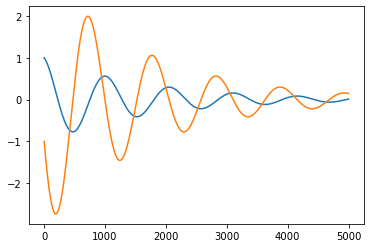

In [4]:
def generate_Theta(X):
    Theta = np.vstack((np.ones_like(X[:,0]),
                    X[:,0], X[:,1],
                    X[:,0]*X[:,0], X[:,1]*X[:,1],
                    X[:,0]*X[:,1])).T
    return Theta

feature_name_list = ["1", "x", "v", "x^2", "v^2", "x v"]
var_list = ["x", "v"]

X, t = generate_data(10, 10/0.002, "harm_osc", xi=0.1)
plt.plot(X)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)
#Theta_sm, X_sm = windowed_generation(Theta, X, t, 5000, 100)

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\n5% Noise: Weak with ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

## 4. Test algorithm with modulated Lotka-Volterra

LOW (5%) MODULATION
Denoised: Without ensembling
[0.84] ni_dot = +     0.67 ni +    -0.99 ni nn 
[0.66] nn_dot = +    -0.33 nn +     0.99 ni nn 

Denoised: With ensembling
[0.84] ni_dot = +     0.67 ni +    -0.99 ni nn 
[0.66] nn_dot = +    -0.33 nn +     0.99 ni nn 

Denoised: Weak without ensembling
[1.00] ni_dot = +     0.66 ni +    -0.99 ni nn 
[1.00] nn_dot = +    -0.34 nn +     1.00 ni nn 


HIGH (30%) MODULATION
5% noise: Without ensembling
[-5.40] ni_dot = +     0.06 1 +     0.56 ni^2 +    -0.82 ni nn 
[-11.31] nn_dot = +     0.08 ni +    -0.30 nn +    -0.01 nn^2 +     0.78 ni nn 

5% noise: With ensembling
[-5.27] ni_dot = +     0.32 ni +     0.38 ni^2 +     0.03 nn^2 +    -0.94 ni nn 
[-11.28] nn_dot = +     0.18 ni +    -0.33 nn +    -0.11 ni^2 +     0.81 ni nn 

5% Noise: Weak without ensembling
[0.93] ni_dot = +     0.67 ni +    -0.96 ni nn 
[0.91] nn_dot = +    -0.08 1 +    -0.22 nn^2 +     1.04 ni nn 


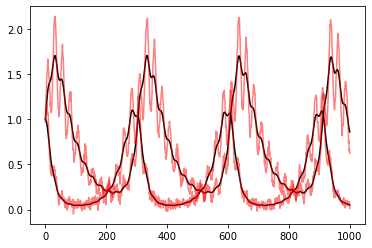

In [5]:
feature_name_list = ["1", "ni", "nn", "ni^2", "nn^2", "ni nn"]
var_list = ["ni", "nn"]

## LOW MODULATION
print("LOW (5%) MODULATION")
X, t = generate_data(50, 1000, "lotka_volterra", A = 0.05)
plt.plot(X, color="black")
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)

opt_coefs = np.zeros((X.shape[1], Theta.shape[1]))

print("Denoised: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\nDenoised: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=32, n_features_to_drop=1,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\nDenoised: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

## HIGH MODULATION
print("\n\nHIGH (30%) MODULATION")
X, t = generate_data(50, 1000, "lotka_volterra", A = 0.3)
X = add_noise(X, 0.05)
plt.plot(X, color="red", alpha=0.5)
X_dot = ps.SmoothedFiniteDifference()(X, t)
Theta = generate_Theta(X)
Theta_sm, X_sm = compute_weak_forms(Theta, X, t)
Theta_sm, X_sm = windowed_generation(Theta, X, t, 1000, 100)

print("5% noise: Without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\n5% noise: With ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta, X_dot, var,
                            n_bootstraps=100, n_features_to_drop=2,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])

print("\n5% Noise: Weak without ensembling")
for var in range(X.shape[1]):
    opt_coefs[var], score = run_search(Theta_sm, X_sm, var,
                            n_bootstraps=1, n_features_to_drop=0,
                            feature_names_list=feature_name_list, print_hierarchy=0)
    print_model(opt_coefs[var], feature_name_list, score, var_list[var])